![spotify_logo](../assets/Spotify_Logo_CMYK_Green.png)

# Spotify Skip Prediction: Feature Engineering and Modelling - Cumulative Average of Session Features
Notebook: 5 of 7

Author: Alex Thach - alcthach@gmail.com  
BrainStation Data Science Capstone Project - Winter 2022  
April 4, 2022
---

# Recap
- In the previous notebook I managed to gather an initial impression of the problem 
- Some insights drawn from my exploratory data analysis appeared to have re-emerged during baseline modelling 
- I.E. Previous user interaction history being a predictor skip outcomes in the following track
- At this point I have conduct a bit of feature engineering and baseline modelling
- The second logit model employed, without `skip_2` and track end behaviours had a test score of about 76%, which outperforms a naive model which if guesses skip every single time would be right 52% of the time
- In other words, the second logit model would guess about 7 songs correctly out of 10, whereas the naive model would guess roughly 5/10 correctly

# Purpose: 
The goal of this notebook is continue with feature engineering and modelling

---

# Summary/Highlights:
- Successfully engineered a cumulative average feature that captures the aggregrate characteristics of user interaction and track features at each point in time during a listening session
- This feature however performed worse than the baseline model from the previous notebook
- Beyond previous user interaction history, the weighing of the history appears to be important in predicting track skip outcome

---

In [1]:
# Runs setup script, imports, plotting settings, reads in raw data
%run -i "../scripts/at-setup.py" 

Dataframes in the global name space now include:
session_logs_df
track_features_df


In [2]:
# Reads in data
main_df = pd.read_csv('../data/processed/merged.csv')
features = pd.read_csv('../data/processed/features.csv')
target = pd.read_csv('../data/processed/target.csv')

## Feature Engineering 

### Cumulative Average Across Listening Session

As it currently stands, a single observation in the dataset represents an instance of a song being played. I know the characteristics of the song being played and how the user interacted with the song. I know some information about the song that preceded it. Namely, how the last song ended, this is by understood by proxy. As I am given information about how the user arrived at the current song. Beyond that, a single-observation cannot tell me about the characteristics of the session, it is limited to the scope of the song. 

However, there might be a way to embed some information about what is happening during the session in terms of user interactions and song characteristics. In other words, I'm looking to transform the data in a way that a single-observation represents what is happening during the user's session on average, and whether this changes how skip outcome is predicted for a particular track. 

I will choose calculate the cumulative average at each position during a listening session. What this effectively tells us is what is the cumulative average of the session characteristics at a certain point in the listening session. Rather than just knowing what the song characteristics are and how the user interacted with the song. I am able to understand on average up to the current song, how has the user behaved, and on average what are the characteristics of the song in the session?

For example, if the cumulative skip rate is 50% up to the current track, how does this affect the model's ability to predict a skip outcome?

I will engineer this feature with the help of pandas, which houses robust functionality when it comes to data manipulation.

In [3]:
# Assigns variables prior to feature engineering
X1 = features
y = target

In [4]:
# Computes the cumulative average of features for all listening sessions in the dataset
# Check to see if the pattern works
X1.groupby('session_id', as_index=True).expanding().mean().reset_index().head()

,session_id,level_1,session_position,session_length,skip_2,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,...,enc__hist_user_behavior_reason_start_trackerror,enc__hist_user_behavior_reason_end_backbtn,enc__hist_user_behavior_reason_end_clickrow,enc__hist_user_behavior_reason_end_endplay,enc__hist_user_behavior_reason_end_fwdbtn,enc__hist_user_behavior_reason_end_logout,enc__hist_user_behavior_reason_end_remote,enc__hist_user_behavior_reason_end_trackdone,enc__mode_major,enc__mode_minor
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0,1.0,20.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,0.000000
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,1.5,20.0,0.0,0.0,0.500000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.500000,0.500000
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,2.0,20.0,0.0,0.0,0.666667,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.666667,0.333333
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,2.5,20.0,0.0,0.0,0.750000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.750000,0.250000
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,3.0,20.0,0.0,0.0,0.800000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.800000,0.200000


In [5]:
%%time
# Will take ~7-8 seconds to run
# Calculates the cumulative average for features in each listening session
# Resets index
# Drops 'level_1' column
X1 = features.groupby('session_id', as_index=False).expanding().mean().reset_index().drop('level_1', axis=1)

# Assigns to X_shifted, will be re-assigned to original dataframe
X1_shifted = X1.groupby('session_id')[['skip_2',   
                                            'enc__hist_user_behavior_reason_end_backbtn',
                                            'enc__hist_user_behavior_reason_end_clickrow',  
                                            'enc__hist_user_behavior_reason_end_endplay',  
                                            'enc__hist_user_behavior_reason_end_fwdbtn',  
                                            'enc__hist_user_behavior_reason_end_logout',
                                            'enc__hist_user_behavior_reason_end_remote',  
                                            'enc__hist_user_behavior_reason_end_trackdone']].shift()

# Re-assigns previous columns to shift columns from above
X1 = X1.assign(**X1_shifted.to_dict(orient='series'))

# Re-assigns 'session_position' to original value Re: I require the original values so that the model has information about where the track is within the session
X1['session_position'] = features['session_position']

Wall time: 7.9 s


Notes on the transformation above:
- `'groupby('session_id')'` was employed to calculate the cumulative average of each feature in the listening session
- After the cumulative averages were calculated, the `'skip_2'` and track end behaviour columns were shifted down a row 
    - If you recall from the previous notebook, I was faced with some data leakage related to both `'skip_2'` and track end behaviour
    - `'skip_2'`  was obvious, but the data leakage caused by the track end behaviours was a bit more nuanced
    - By shift the columns down by one row, the current observation is now blind to what it's own skip and track end behaviour, and now sees the cumulative averages for these features, not include the current track
    - In other words, the observation stores information about the cumulative averages in skip and track end behaviours, on average, how much has the user been skipped, or how have the tracks been ending?
- Next I reassigned the `'session_position'` values, to return the column back to the original values, which helps me to maintain the sequential information in the dataset
- Finally, I dropped `'session_id'` as this is the final version of the transform dataset, with cumulative average as a feature

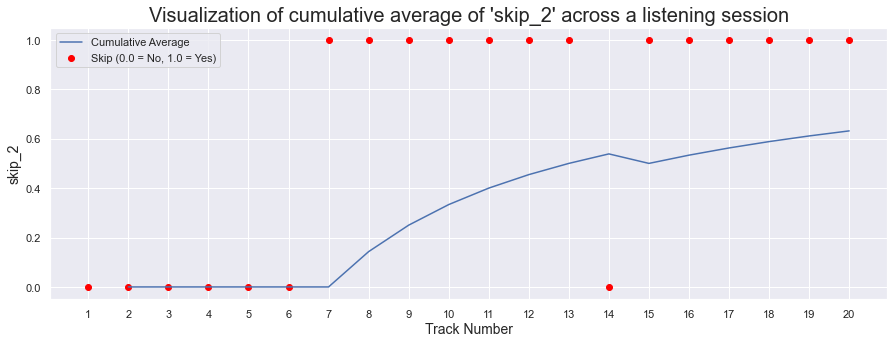

In [6]:
# New index to shift cumulative average plot to reflect a lag
new_index = X1[X1['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e']['skip_2'].index + 1

# Plots 'skip_2' and cumulative average
plt.figure()
plt.plot(X1[X1['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e'][['skip_2']].set_index(new_index), label='Cumulative Average')
plt.scatter(main_df[main_df['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e']['session_position'],
            main_df[main_df['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e']['skip_2'], color = 'red', label = 'Skip (0.0 = No, 1.0 = Yes)')
plt.title("Visualization of cumulative average of 'skip_2' across a listening session")
plt.xlabel('Track Number')
plt.ylabel('skip_2')
plt.legend()
plt.xticks(main_df[main_df['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e']['session_position'])
plt.show()


The figure above helps visualize what happens when cumulative average is computed across a listening session. In this session, the user listened to the first 6 songs until the end. Just a reminder that the cumulative average computation was staggered by one row for `'skip_2'` which explains why the blue line plot representing the cumulative average skip rate begins at track 2. At the 7th song, the cumulative average for skip remains at 0 despite this track being skipped. As the following 6 songs are skipped. The cumulative average skip rate starts to climb. 

In essence, this feature captures what's happens in aggregrate during the session.

---

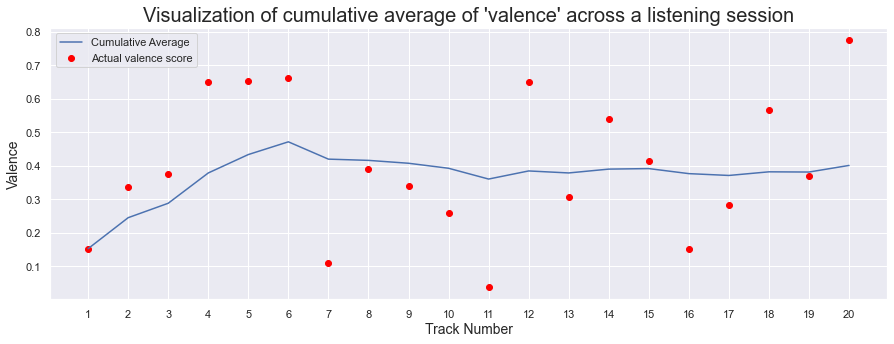

In [7]:
# New index to shift cumulative average plot to reflect a lag
new_index = X1[X1['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e']['skip_2'].index + 1

# Plots 'skip_2' and cumulative average
# plt.figure()
# X1[X1['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e'][['valence']].set_index(new_index).plot(label='Cumulative Average')
plt.plot(X1[X1['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e'][['valence']].set_index(new_index), label=('Cumulative Average'))
plt.scatter(main_df[main_df['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e']['session_position'],
            main_df[main_df['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e']['valence'], color = 'red', label = 'Actual valence score')
plt.title("Visualization of cumulative average of 'valence' across a listening session")
plt.xlabel('Track Number')
plt.ylabel('Valence')
plt.legend()
plt.xticks(main_df[main_df['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e']['session_position'])
plt.show()

Here I provide another example of the mechanics of cumulative average. This time using valence, a measure of the happinesss or sadness of a song. You can see that can valence cumulative tracks quite constant beyond the 7th track or so. However, the actual valence of the tracks varies quite a bit from looking at the red points that indicate the valence of the individual tracks. In general, an single observation now explains where the average characteristics of the session is at a certain point in time. I will now see how this new feature performs with a baseline Logit classifier.

---

In [8]:
# Drops 'session_id' column
X1.drop('session_id', axis=1, inplace=True)

Quick check to see the data I'm working with

In [9]:
X1.head()

,session_position,session_length,skip_2,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,...,enc__hist_user_behavior_reason_start_trackerror,enc__hist_user_behavior_reason_end_backbtn,enc__hist_user_behavior_reason_end_clickrow,enc__hist_user_behavior_reason_end_endplay,enc__hist_user_behavior_reason_end_fwdbtn,enc__hist_user_behavior_reason_end_logout,enc__hist_user_behavior_reason_end_remote,enc__hist_user_behavior_reason_end_trackdone,enc__mode_major,enc__mode_minor
0,1,20.0,NaN,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
1,2,20.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.500000,0.500000
2,3,20.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.666667,0.333333
3,4,20.0,0.0,0.0,0.750000,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.750000,0.250000
4,5,20.0,0.0,0.0,0.800000,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.800000,0.200000


In [10]:
y.head()

,skip_2
0,False
1,False
2,False
3,False
4,False


### Modelling New Feature with Logit Classifier 

In [11]:
# Splitting into remainder and test sets
X1_remainder, X1_test, y1_remainder, y1_test = \
    train_test_split(X1, y, test_size = 0.2,
                     random_state=42)

In [12]:
# Splitting the remainder into train and validation
X1_train, X1_validation, y1_train, y1_validation = \
    train_test_split(X1_remainder, y1_remainder, test_size = 0.3,
                     random_state=42)

In [13]:
# Instantiates Logit
logit = LogisticRegression(max_iter=500, verbose=1, n_jobs=-1)

# Fits
logit.fit(X1_train, y1_train)

# Scores on train and validation
print(logit.score(X1_train, y1_train))
print(logit.score(X1_validation, y1_validation))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

We'll make an important assumption here. We'll begin our predictions at the second track of every session. Rather than at the first track.

In [14]:
X1[X1['session_position'] == 1]

,session_position,session_length,skip_2,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,...,enc__hist_user_behavior_reason_start_trackerror,enc__hist_user_behavior_reason_end_backbtn,enc__hist_user_behavior_reason_end_clickrow,enc__hist_user_behavior_reason_end_endplay,enc__hist_user_behavior_reason_end_fwdbtn,enc__hist_user_behavior_reason_end_logout,enc__hist_user_behavior_reason_end_remote,enc__hist_user_behavior_reason_end_trackdone,enc__mode_major,enc__mode_minor
0,1,20.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
20,1,20.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
40,1,20.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
60,1,20.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
80,1,11.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167788,1,20.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
167808,1,20.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
167828,1,20.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
167848,1,12.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0


The cell output above returns each of the first tracks in every listening session in the dataset. If you remember, I had shifted the `'skip_2'` to prevent data leakage. As a result I cannot predict first track skip due to the presence of missing values. An assumption I'll make here is that I will begin predictions at the second track. So we'll remove the first tracks from the dataset.

In [15]:
# Sanity check, seeing what the mask used for dropping first tracks looks like
X1[X1['session_position'] == 1].index

Int64Index([     0,     20,     40,     60,     80,     91,    106,    121,
               141,    161,
            ...
            167702, 167722, 167742, 167754, 167774, 167788, 167808, 167828,
            167848, 167860],
           dtype='int64', length=10000)

This means the target variable also needs to be transformed.

In [16]:
# Drops first songs in target variable using the mask from dropping first songs in X1
y.drop(X1[X1['session_position'] == 1].index, inplace=True)

In [17]:
# Drops the first song of each listening session
X1.drop(X1[X1['session_position'] == 1].index, inplace=True)

In [18]:
# Sanity check
X1.head()

,session_position,session_length,skip_2,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,...,enc__hist_user_behavior_reason_start_trackerror,enc__hist_user_behavior_reason_end_backbtn,enc__hist_user_behavior_reason_end_clickrow,enc__hist_user_behavior_reason_end_endplay,enc__hist_user_behavior_reason_end_fwdbtn,enc__hist_user_behavior_reason_end_logout,enc__hist_user_behavior_reason_end_remote,enc__hist_user_behavior_reason_end_trackdone,enc__mode_major,enc__mode_minor
1,2,20.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.500000,0.500000
2,3,20.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.666667,0.333333
3,4,20.0,0.0,0.0,0.750000,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.750000,0.250000
4,5,20.0,0.0,0.0,0.800000,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.800000,0.200000
5,6,20.0,0.0,0.0,0.833333,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.666667,0.333333


In [19]:
# Another sanity check to insure the indices match
all(X1.index == y.index)

True

In [20]:
# Re-assigns y to correct dimensions
y = y['skip_2']

Now that I successfully dropped the first tracks of each session from both X1, and y, I will proceed to fit a Logit classifier to see how the new engineered feature performs.

In [21]:
# Splitting into remainder and test sets
X1_remainder, X1_test, y1_remainder, y1_test = \
    train_test_split(X1, y, test_size = 0.2,
                     random_state=42)

In [22]:
# Splitting the remainder into train and validation
X1_train, X1_validation, y1_train, y1_validation = \
    train_test_split(X1_remainder, y1_remainder, test_size = 0.3,
                     random_state=42)

In [23]:
# Note: This cell will take some time to run
# Instantiates Logit
logit = LogisticRegression(max_iter=500, verbose=1, n_jobs=-1, random_state=42)

# Fits (Estimated runtime: ~1-2 min)
logit.fit(X1_train, y1_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.3min finished


LogisticRegression(max_iter=500, n_jobs=-1, random_state=42, verbose=1)

In [24]:
# Scores on train and validation
print(f"Train score: {logit.score(X1_train, y1_train):.2f}")
print(f"Validation score: {logit.score(X1_validation, y1_validation):.2f}")

Train score: 0.69
Validation score: 0.69


### Discussion
The newly engineered feature appears to perform markedly worse than the model constructed in the previous notebook. However, it was worth experimenting just to see what the outcome might have been. I suspect that cumulative average might not have performed that well due to the fact that this feature weighs all tracks in the session equally. In other words, the model considers the first track to be just as important in predicting track skip as compared to the current or preceding track. For example, when trying to predict skip outcome at the 17th track in the session, we'd assume that there is little impact from the first track in deciding whether the current track would be skipped. 

That is to say, I would have to consider shifting the weights of the calculations to favour the most immediate tracks. To predict a track skip, I'd be better served placing more importance on the tracks that precede it.

In the next notebook I will explore this notion, attempting to engineer a feature that captures the characteristics of the session closer to the current track.

---

## Wrapping Up
- I moved on from the baseline feature engineering and modelling from the previous notebook, and looked to explore the outcome of encoding session characteristics into a single observation
- Instead of a single row in the data representing the song characteristics and how the user interacted with the song, I wanted to capture the aggregrate characteristics of the session at that point in time
- I successfully transformed the dataset, and minimized the threat of data leakage by staggering skip and track end behaviours by one observation (or song)
- In general the model performed worse than the baseline model from the last notebook, this is likely due to the equal weighting of each observation 
- **So far in the project, the findings seem to suggest that previous user interaction history, and weighing of this history appear to have an important effect on predicting skip outcomes of each track**

---

# Next Steps:
- In the next notebook I will continue experimenting with feature engineering
- With a focus on encoding session information that favours user interaction and track features closer to the track I'm trying to predict